
3D MRI Super Resolution
==============
Author: Huixiang Zhuang, Hadrien Cornier




##  Overview

Magnetic resonance imaging (MRI) is a powerful diagnostic imaging technique. But the biggest problem is the trade off between high quality scan and long scanning time. High resolution MRI are hardware demanding, and prone to motion artifacts. Nowadays, neural network researches on image superresolution have focus on MR super resoltuion, in order to make cheaper, and faster scans.

We referred to multi-level densely connected super-resolution network (mDCSRN) and merged it with the idea of generative adversarial learning, to perform super resolution on MR images. 

In [3]:
from __future__ import print_function
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import random
import time
import math
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg
from scipy import ndimage
import pandas as pd
from IPython.display import HTML
plt.ion()   # interactive mode

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
# from torch.optim import lr_scheduler


# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


## Input

**Parameter setting**

Here we define some inputs for the run:

-  **vm_PATH** - the path of folder in your local machine that mounts google storage 
-  **id_csv** - the path to the .csv file that has id of subjects
-  **workers** - the number of worker threads for loading the data with
   the DataLoader
-  **batch_size** - the batch size here in fact determine the number of samples once download. We uses a batch size of 2
-  **patch_size** - the patch size here in fact determine the number of images (cubes) as the input in one training. We uses a patch size of 2 as is recommended in the paper
-  **cube_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64x64. If another size is desired,
   the structures of D and G must be changed. See
   `here <https://github.com/pytorch/examples/issues/70>`__ for more
   details
-  **usage** - the usage of a patch cluster. usage < 1.0 would mean we choose to randomly give up some patches by this probability
-  **num_steps_pre** - the pretraining steps of Generator. By default in paper, this should be 500000. Here we use 250000. 
-  **num_steps** - the total steps of training. By default in paper, this should be $500000+550000=1050000$. Here we use 550000. 
-  **first_steps** - the total number of WGAN Discriminator pre-training steps. By default in paper, this should be 10000. Here we use 10000.
-  **lr_pre** - learning rate for pretraining. As described in the paper, this number should be 1e-4.
-  **lr** - learning rate for WGAN training. As described in the paper, this number should be 5e-6.
-  **ngpu** - number of GPUs available. If this is 0, code will run in
   CPU mode. If this number is greater than 0 it will run on that number
   of GPUs
-  **device** - CUDA setting. 



In [4]:
# Set pathes
vm_PATH = "./mnt/superresolution/HCP_1200/"
id_csv = './csv/id_hcp.csv'

# Number of workers for dataloader
workers = 1

# Batch size. It controls the number of samples once download
batch_size = 16

# Patch size, it controls the number of patches once send into the model
patch_size = 2

# The size of one image patch (eg. 64 means a cubic patch with size: 64x64x64)
cube_size = 64

# Set the usage of a patch cluster.
usage = 1.0

# Number of mDCSRN (G) pre-training steps (5e6)
num_steps_pre = 250000

# Number of WGAN training steps (1.5e7)
num_steps = 550000

# Number of WGAN D pre-training steps (1e4)
first_steps = 10000

# Learning rate for mDCSRN (G) pre-training optimizers (in paper: 1e-4)
lr_pre = 1e-4

# Learning rate for optimizers (in paper: 5e-6)
lr = 5e-6

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

# set GPU device
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

## Data loading with online fetching, and patching



In [5]:
from ecbm6040.dataloader.CustomDatasetFromCSV import CustomDatasetFromCSV

from ecbm6040.patching.patchloader import patching

**Split data**

In [6]:
# Set percentage of data spliting
train_split= 0.7
validate_split = 0.1
evaluate_split = 0.1
test_split = 0.1

# Set shuffle and stablize random_seed
shuffle_dataset = True
random_seed= 999

# load data from csv
dataset = CustomDatasetFromCSV(id_csv,vm_PATH)
dataset_size = len(dataset)

# get indices for spliting train, valiadate, evaluate, test sets
train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
evaluate_size = int(evaluate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size - evaluate_size)

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices = indices[:train_size]
# To reduce computational cost in validation period, you can intentionally decrease the validation size. 
loc_val = train_size + validate_size
# loc_val_reduced = train_size + math.ceil(validate_size/3)
# val_indices = indices[train_size:loc_val_reduced]
val_indices = indices[train_size:loc_val]
loc_eval = loc_val + evaluate_size
eval_indices = indices[loc_val:loc_eval]
test_indices = indices[loc_eval:loc_eval+4]
num_train = len(train_indices)
num_val = len(val_indices)
num_eval = len(eval_indices)
num_test = len(test_indices)
print('training set number:{}'.format(len(train_indices)))
print('validation set number:{}'.format(len(val_indices)))
print('evaluation set number:{}'.format(len(eval_indices)))
print('test set number:{}'.format(len(test_indices)))

training set number:780
validation set number:111
evaluation set number:111
test set number:4


**The following cell create dataloaders used for pretraining.**

In [7]:
# Use for pre-training (we don't want too much validation)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
eval_sampler = SubsetRandomSampler(eval_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
eval_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=eval_sampler,
                                        shuffle=False,
                                        num_workers=workers)
test_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=test_sampler,
                                        shuffle=False,
                                        num_workers=workers)


dataloaders={'train':train_loader, 'val':validation_loader}
dataset_sizes={'train':len(train_sampler), 'val':len(valid_sampler)}

**The following cell create dataloaders used for WGAN training.**

Since we want more frequent validation to track the performance, we make training dataloaders and validation dataloaders to be interleaved.

In [8]:
# Use for WGAN-training (we want to have more frequent validation)
def chunks(arr, m):
    '''
    This function split the list into m fold.
    '''
    n = int(np.floor(len(arr) / float(m)))
    arr_split = [arr[i:i + n] for i in range(0, len(arr), n)]
    return arr_split

# Split indices
train_indices_split = chunks(train_indices, 10)
val_indices_split = chunks(val_indices, 10)

dataloaders={'train':[], 'val':[]}
dataset_sizes={'train':[], 'val':[]}
for i in range(10):
    train_sampler = SubsetRandomSampler(train_indices_split[i])
    valid_sampler = SubsetRandomSampler(val_indices_split[i])
    train_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=train_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    validation_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                        batch_size=batch_size, 
                                        sampler=valid_sampler,
                                        shuffle=False,
                                        num_workers=workers)
    dataloaders['train'].append(train_loader)
    dataloaders['val'].append(validation_loader)
#     dataset_sizes['train'].append(len(train_indices_split[i]))
#     dataset_sizes['val'].append(len(val_indices_split[i]))

# Implementation: Modeling



**Weight Initialization**



In [9]:
# custom weights initialization called on netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('LayerNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator**:

![Structure of Generator](./example_images/Generator.png)

In [10]:
from ecbm6040.model.mDCSRN_WGAN import Generator

# Create the generator
netG = Generator(ngpu).cuda(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Print the model
print(netG)
print('# generator parameters:', sum(param.numel() for param in netG.parameters()))

DataParallel(
  (module): Generator(
    (conv0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    (block0): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm): BatchNorm3d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(48, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      )
      (denselayer3): _DenseLayer(
        (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (elu): ELU(alpha=1.0, inplace)
        (conv): Conv3d(64, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
     

**Discriminator**:

![Structure of Discriminator](./example_images/Discriminator.png)

In [11]:
from ecbm6040.model.mDCSRN_WGAN import Discriminator

# Create the Discriminator
netD = Discriminator(ngpu).cuda(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
print('# discriminator parameters:', sum(param.numel() for param in netD.parameters()))

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (3): LayerNorm(torch.Size([64, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (4): LeakyReLU(negative_slope=0.2)
      (5): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (6): LayerNorm(torch.Size([128, 32, 32, 32]), eps=1e-05, elementwise_affine=True)
      (7): LeakyReLU(negative_slope=0.2)
      (8): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (9): LayerNorm(torch.Size([128, 16, 16, 16]), eps=1e-05, elementwise_affine=True)
      (10): LeakyReLU(negative_slope=0.2)
      (11): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (12): LayerNorm(torch.Size([256, 16, 16, 16]), eps=1e-05, elementw

In [12]:
# Initialize Loss functions
supervised_criterion = nn.L1Loss()
# We move wasserstein Loss into the training function.

## Training

Training scheme: 

1) non-GAN training: pretrain the generator for 250k steps, use learning rate 1e-4, L1-loss;

2) With GAN training: 550k steps together with the pretraining steps, use learning rate 5e-6,
$$
\operatorname{loss}=\operatorname{loss}_{\text { int }}+\lambda \operatorname{loss}_{\text { GAN }}
$$

where $\operatorname{loss}_{\mathrm{GAN}}=\operatorname{loss}_{\mathrm{WGAN}, D}=-D_{\mathrm{WGAN}, \theta}\left(I^{\mathrm{SR}}\right).$

3) Train discriminator alone for 10k steps;

4) Imbalanced training: train D 7 steps, train G 1 step;

5) Every 500 steps train D alone for an extra 200 steps. 

**Pretraining Generator (mDCSRN)**

In [14]:
from training_pre import training_pre

In [11]:
model=training_pre(netG, dataloaders, 
                   dataset_sizes, supervised_criterion, 
                   device, ngpu, max_step=num_steps_pre, 
                   lr=lr_pre, patch_size=patch_size, pretrained='models/pretrained_G_step225000')

Generator pre-training...
Step 225000/250000
----------


/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'ecbm6040.model.mDCSRN_WGAN.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Step: 225500, loss= 0.0081
Step: 226000, loss= 0.0044
Step: 226500, loss= 0.0055
Step: 227000, loss= 0.0046
Step: 227500, loss= 0.0061
Step: 228000, loss= 0.0041
Step: 228500, loss= 0.0046
Step: 229000, loss= 0.0039
Step: 229500, loss= 0.0039
Step: 230000, loss= 0.0047
Step: 230500, loss= 0.0061
Step: 231000, loss= 0.0050
Step: 231500, loss= 0.0048
Step: 232000, loss= 0.0045
Step: 232500, loss= 0.0041
Step: 233000, loss= 0.0046
Step: 233500, loss= 0.0040
Step: 234000, loss= 0.0077
Step: 234500, loss= 0.0068
Step: 235000, loss= 0.0044
Step: 235500, loss= 0.0048
Step: 236000, loss= 0.0055
Step: 236500, loss= 0.0064
Step: 237000, loss= 0.0039
Step: 237500, loss= 0.0092
Step: 238000, loss= 0.0051
Step: 238500, loss= 0.0045
Step: 239000, loss= 0.0059
Step: 239500, loss= 0.0042
Step: 240000, loss= 0.0058
Step: 240500, loss= 0.0060
Step: 241000, loss= 0.0075
Step: 241500, loss= 0.0041
Step: 242000, loss= 0.0057
Step: 242500, loss= 0.0048
Step: 243000, loss= 0.0065
Step: 243500, loss= 0.0040
S

Step: 244500, loss= 0.0210
Step: 244500, loss= 0.0154
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0127
Step: 244500, loss= 0.0119
Step: 244500, loss= 0.0065
Step: 244500, loss= 0.0183
Step: 244500, loss= 0.0160
Step: 244500, loss= 0.0122
Step: 244500, loss= 0.0094
Step: 244500, loss= 0.0046
Step: 244500, loss= 0.0102
Step: 244500, loss= 0.0128
Step: 244500, loss= 0.0167
Step: 244500, loss= 0.0126
Step: 244500, loss= 0.0105
Step: 244500, loss= 0.0037
Step: 244500, loss= 0.0228
Step: 244500, loss= 0.0196
Step: 244500, loss= 0.0205
Step: 244500, loss= 0.0155
Step: 244500, loss= 0.0175
Step: 244500, loss= 0.0133
Step: 244500, loss= 0.0178
Step: 244500, loss= 0.0267
Step: 244500, loss= 0.0209
Step: 244500, loss= 0.0142
Step: 244500, loss= 0.0152
Step: 244500, loss= 0.0147
Step: 244500, loss= 0.0159
Step: 244500, loss= 0.0079
Step: 244500, loss= 0.0185
Step: 244500, loss= 0.0129
Step: 244500, loss= 0.0129
Step: 244500, loss= 0.0094
Step: 244500, loss= 0.0043
Step: 244500, loss= 0.0090
S

Step: 244500, loss= 0.0114
Step: 244500, loss= 0.0054
Step: 244500, loss= 0.0230
Step: 244500, loss= 0.0192
Step: 244500, loss= 0.0123
Step: 244500, loss= 0.0086
Step: 244500, loss= 0.0036
Step: 244500, loss= 0.0090
Step: 244500, loss= 0.0209
Step: 244500, loss= 0.0189
Step: 244500, loss= 0.0199
Step: 244500, loss= 0.0160
Step: 244500, loss= 0.0049
Step: 244500, loss= 0.0277
Step: 244500, loss= 0.0302
Step: 244500, loss= 0.0390
Step: 244500, loss= 0.0339
Step: 244500, loss= 0.0369
Step: 244500, loss= 0.0188
Step: 244500, loss= 0.0201
Step: 244500, loss= 0.0365
Step: 244500, loss= 0.0415
Step: 244500, loss= 0.0360
Step: 244500, loss= 0.0259
Step: 244500, loss= 0.0260
Step: 244500, loss= 0.0203
Step: 244500, loss= 0.0083
Step: 244500, loss= 0.0280
Step: 244500, loss= 0.0232
Step: 244500, loss= 0.0181
Step: 244500, loss= 0.0129
Step: 244500, loss= 0.0051
Step: 244500, loss= 0.0098
Step: 244500, loss= 0.0154
Step: 244500, loss= 0.0146
Step: 244500, loss= 0.0121
Step: 244500, loss= 0.0098
S

Step: 244500, loss= 0.0156
Step: 244500, loss= 0.0106
Step: 244500, loss= 0.0045
Step: 244500, loss= 0.0053
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0130
Step: 244500, loss= 0.0121
Step: 244500, loss= 0.0035
Step: 244500, loss= 0.0147
Step: 244500, loss= 0.0179
Step: 244500, loss= 0.0226
Step: 244500, loss= 0.0166
Step: 244500, loss= 0.0198
Step: 244500, loss= 0.0083
Step: 244500, loss= 0.0105
Step: 244500, loss= 0.0239
Step: 244500, loss= 0.0241
Step: 244500, loss= 0.0203
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0124
Step: 244500, loss= 0.0080
Step: 244500, loss= 0.0072
Step: 244500, loss= 0.0192
Step: 244500, loss= 0.0148
Step: 244500, loss= 0.0112
Step: 244500, loss= 0.0084
Step: 244500, loss= 0.0032
Step: 244500, loss= 0.0082
Step: 244500, loss= 0.0151
Step: 244500, loss= 0.0159
Step: 244500, loss= 0.0113
Step: 244500, loss= 0.0103
Step: 244500, loss= 0.0039
Step: 244500, loss= 0.0189
Step: 244500, loss= 0.0207
Step: 244500, loss= 0.0212
S

Step: 244500, loss= 0.0168
Step: 244500, loss= 0.0127
Step: 244500, loss= 0.0100
Step: 244500, loss= 0.0034
Step: 244500, loss= 0.0196
Step: 244500, loss= 0.0200
Step: 244500, loss= 0.0209
Step: 244500, loss= 0.0148
Step: 244500, loss= 0.0163
Step: 244500, loss= 0.0090
Step: 244500, loss= 0.0134
Step: 244500, loss= 0.0259
Step: 244500, loss= 0.0220
Step: 244500, loss= 0.0143
Step: 244500, loss= 0.0127
Step: 244500, loss= 0.0113
Step: 244500, loss= 0.0097
Step: 244500, loss= 0.0097
Step: 244500, loss= 0.0210
Step: 244500, loss= 0.0111
Step: 244500, loss= 0.0099
Step: 244500, loss= 0.0071
Step: 244500, loss= 0.0036
Step: 244500, loss= 0.0055
Step: 244500, loss= 0.0102
Step: 244500, loss= 0.0111
Step: 244500, loss= 0.0093
Step: 244500, loss= 0.0067
Step: 244500, loss= 0.0030
Step: 244500, loss= 0.0158
Step: 244500, loss= 0.0147
Step: 244500, loss= 0.0188
Step: 244500, loss= 0.0151
Step: 244500, loss= 0.0153
Step: 244500, loss= 0.0063
Step: 244500, loss= 0.0089
Step: 244500, loss= 0.0200
S

Step: 244500, loss= 0.0338
Step: 244500, loss= 0.0444
Step: 244500, loss= 0.0377
Step: 244500, loss= 0.0402
Step: 244500, loss= 0.0265
Step: 244500, loss= 0.0354
Step: 244500, loss= 0.0403
Step: 244500, loss= 0.0468
Step: 244500, loss= 0.0377
Step: 244500, loss= 0.0300
Step: 244500, loss= 0.0284
Step: 244500, loss= 0.0302
Step: 244500, loss= 0.0189
Step: 244500, loss= 0.0577
Step: 244500, loss= 0.0449
Step: 244500, loss= 0.0287
Step: 244500, loss= 0.0237
Step: 244500, loss= 0.0092
Step: 244500, loss= 0.0075
Step: 244500, loss= 0.0141
Step: 244500, loss= 0.0134
Step: 244500, loss= 0.0113
Step: 244500, loss= 0.0112
Step: 244500, loss= 0.0039
Step: 244500, loss= 0.0211
Step: 244500, loss= 0.0211
Step: 244500, loss= 0.0221
Step: 244500, loss= 0.0163
Step: 244500, loss= 0.0196
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0153
Step: 244500, loss= 0.0279
Step: 244500, loss= 0.0234
Step: 244500, loss= 0.0175
Step: 244500, loss= 0.0147
Step: 244500, loss= 0.0149
Step: 244500, loss= 0.0138
S

Step: 244500, loss= 0.0095
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0240
Step: 244500, loss= 0.0244
Step: 244500, loss= 0.0192
Step: 244500, loss= 0.0135
Step: 244500, loss= 0.0151
Step: 244500, loss= 0.0093
Step: 244500, loss= 0.0064
Step: 244500, loss= 0.0181
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0109
Step: 244500, loss= 0.0073
Step: 244500, loss= 0.0035
Step: 244500, loss= 0.0049
Step: 244500, loss= 0.0143
Step: 244500, loss= 0.0128
Step: 244500, loss= 0.0115
Step: 244500, loss= 0.0088
Step: 244500, loss= 0.0033
Step: 244500, loss= 0.0202
Step: 244500, loss= 0.0197
Step: 244500, loss= 0.0270
Step: 244500, loss= 0.0252
Step: 244500, loss= 0.0213
Step: 244500, loss= 0.0096
Step: 244500, loss= 0.0112
Step: 244500, loss= 0.0222
Step: 244500, loss= 0.0310
Step: 244500, loss= 0.0280
Step: 244500, loss= 0.0154
Step: 244500, loss= 0.0108
Step: 244500, loss= 0.0080
Step: 244500, loss= 0.0051
Step: 244500, loss= 0.0187
Step: 244500, loss= 0.0151
Step: 244500, loss= 0.0090
S

Step: 244500, loss= 0.0124
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0099
Step: 244500, loss= 0.0054
Step: 244500, loss= 0.0155
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0099
Step: 244500, loss= 0.0080
Step: 244500, loss= 0.0039
Step: 244500, loss= 0.0069
Step: 244500, loss= 0.0178
Step: 244500, loss= 0.0157
Step: 244500, loss= 0.0165
Step: 244500, loss= 0.0126
Step: 244500, loss= 0.0035
Step: 244500, loss= 0.0271
Step: 244500, loss= 0.0270
Step: 244500, loss= 0.0353
Step: 244500, loss= 0.0325
Step: 244500, loss= 0.0280
Step: 244500, loss= 0.0117
Step: 244500, loss= 0.0142
Step: 244500, loss= 0.0297
Step: 244500, loss= 0.0390
Step: 244500, loss= 0.0354
Step: 244500, loss= 0.0232
Step: 244500, loss= 0.0168
Step: 244500, loss= 0.0100
Step: 244500, loss= 0.0068
Step: 244500, loss= 0.0235
Step: 244500, loss= 0.0192
Step: 244500, loss= 0.0127
Step: 244500, loss= 0.0097
Step: 244500, loss= 0.0035
Step: 244500, loss= 0.0063
Step: 244500, loss= 0.0193
Step: 244500, loss= 0.0184
S

Step: 244500, loss= 0.0324
Step: 244500, loss= 0.0231
Step: 244500, loss= 0.0164
Step: 244500, loss= 0.0111
Step: 244500, loss= 0.0059
Step: 244500, loss= 0.0080
Step: 244500, loss= 0.0254
Step: 244500, loss= 0.0282
Step: 244500, loss= 0.0264
Step: 244500, loss= 0.0190
Step: 244500, loss= 0.0045
Step: 244500, loss= 0.0300
Step: 244500, loss= 0.0390
Step: 244500, loss= 0.0585
Step: 244500, loss= 0.0519
Step: 244500, loss= 0.0471
Step: 244500, loss= 0.0156
Step: 244500, loss= 0.0162
Step: 244500, loss= 0.0397
Step: 244500, loss= 0.0644
Step: 244500, loss= 0.0602
Step: 244500, loss= 0.0330
Step: 244500, loss= 0.0250
Step: 244500, loss= 0.0152
Step: 244500, loss= 0.0077
Step: 244500, loss= 0.0361
Step: 244500, loss= 0.0350
Step: 244500, loss= 0.0193
Step: 244500, loss= 0.0142
Step: 244500, loss= 0.0044
Step: 244500, loss= 0.0041
Step: 244500, loss= 0.0143
Step: 244500, loss= 0.0137
Step: 244500, loss= 0.0136
Step: 244500, loss= 0.0104
Step: 244500, loss= 0.0034
Step: 244500, loss= 0.0172
S

Step: 244500, loss= 0.0037
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0118
Step: 244500, loss= 0.0111
Step: 244500, loss= 0.0087
Step: 244500, loss= 0.0029
Step: 244500, loss= 0.0125
Step: 244500, loss= 0.0162
Step: 244500, loss= 0.0215
Step: 244500, loss= 0.0185
Step: 244500, loss= 0.0174
Step: 244500, loss= 0.0061
Step: 244500, loss= 0.0065
Step: 244500, loss= 0.0192
Step: 244500, loss= 0.0233
Step: 244500, loss= 0.0219
Step: 244500, loss= 0.0132
Step: 244500, loss= 0.0088
Step: 244500, loss= 0.0060
Step: 244500, loss= 0.0040
Step: 244500, loss= 0.0163
Step: 244500, loss= 0.0127
Step: 244500, loss= 0.0100
Step: 244500, loss= 0.0072
Step: 244500, loss= 0.0029
Step: 244500, loss= 0.0079
Step: 244500, loss= 0.0150
Step: 244500, loss= 0.0156
Step: 244500, loss= 0.0132
Step: 244500, loss= 0.0110
Step: 244500, loss= 0.0040
Step: 244500, loss= 0.0229
Step: 244500, loss= 0.0206
Step: 244500, loss= 0.0272
Step: 244500, loss= 0.0194
Step: 244500, loss= 0.0194
Step: 244500, loss= 0.0108
S

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7fb484d1bcf8>>
Traceback (most recent call last):
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.cur

**Training mDCSRN+SRGAN**

In [15]:
from WGAN_GP import WGAN_GP

In [12]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, device)
model_G, model_D = wgan_gp.training(dataloaders, max_step=num_steps, first_steps=first_steps, patch_size=patch_size, pretrainedG='models/WGAN_G_step370000', pretrainedD='models/WGAN_D_step370000')

WGAN training...
Step 370000/550000
----------
Step: 370500, loss= 0.0041, D_loss= -0.0000, G_loss= -0.0005
Step: 371000, loss= 0.0046, D_loss= -0.0112, G_loss= -0.0005
Step: 371500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 372000, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 372500, loss= 0.0040, D_loss= -0.0000, G_loss= -0.0005
Step: 373000, loss= 0.0040, D_loss= 0.0000, G_loss= -0.0005
Step: 373500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
No.1 train period. Mean main loss: 0.0169. Mean discriminator loss: -0.0145
No. 1 val period. Mean main loss: 0.0157. Mean discriminator loss: -0.0077.
Metrics: subject-wise mean SSIM = 0.9208, std = 0.0318; mean PSNR = 28.8512, std = 1.6339; mean NRMSE = 0.3630, std = 0.0315.
Now the training uses 32m 47s

Step: 374000, loss= 0.0035, D_loss= -0.0000, G_loss= -0.0005
Step: 374500, loss= 0.0043, D_loss= -0.0121, G_loss= -0.0005
Step: 375000, loss= 0.0043, D_loss= -0.0000, G_loss= -0.0005
Step: 375500, loss= 0.0040, D_loss=

Step: 412000, loss= 0.0038, D_loss= -0.0015, G_loss= -0.0005
Step: 412500, loss= 0.0037, D_loss= -0.0000, G_loss= -0.0005
No.1 train period. Mean main loss: 0.0169. Mean discriminator loss: -0.0145
No. 1 val period. Mean main loss: 0.0159. Mean discriminator loss: -0.0063.
Metrics: subject-wise mean SSIM = 0.9217, std = 0.0273; mean PSNR = 28.8462, std = 1.5593; mean NRMSE = 0.3629, std = 0.0282.
Now the training uses 361m 4s

Step: 413000, loss= 0.0040, D_loss= -0.0000, G_loss= -0.0005
Step: 413500, loss= 0.0037, D_loss= -0.0000, G_loss= -0.0005
Step: 414000, loss= 0.0044, D_loss= -0.0000, G_loss= -0.0005
Step: 414500, loss= 0.0038, D_loss= -0.0051, G_loss= -0.0005
Step: 415000, loss= 0.0036, D_loss= -0.0000, G_loss= -0.0005
Step: 415500, loss= 0.0039, D_loss= -0.0000, G_loss= -0.0005
Step: 416000, loss= 0.0043, D_loss= -0.0118, G_loss= -0.0005
Step: 416500, loss= 0.0043, D_loss= -0.0106, G_loss= -0.0005
No.2 train period. Mean main loss: 0.0167. Mean discriminator loss: -0.0142
No. 2

Step: 452000, loss= 0.0036, D_loss= -0.0000, G_loss= -0.0005
Step: 452500, loss= 0.0041, D_loss= -0.0002, G_loss= -0.0005
Step: 453000, loss= 0.0036, D_loss= -0.0000, G_loss= -0.0005
Step: 453500, loss= 0.0044, D_loss= -0.0000, G_loss= -0.0005
Step: 454000, loss= 0.0040, D_loss= -0.0000, G_loss= -0.0005
Step: 454500, loss= 0.0039, D_loss= -0.0116, G_loss= -0.0005
Step: 455000, loss= 0.0041, D_loss= -0.0000, G_loss= -0.0005
Step: 455500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
No.2 train period. Mean main loss: 0.0167. Mean discriminator loss: -0.0142
No. 2 val period. Mean main loss: 0.0129. Mean discriminator loss: -0.0111.
Metrics: subject-wise mean SSIM = 0.9298, std = 0.0111; mean PSNR = 29.9248, std = 0.9524; mean NRMSE = 0.2584, std = 0.0101.
Now the training uses 722m 1s

Step: 456000, loss= 0.0039, D_loss= -0.0000, G_loss= -0.0005
Step: 456500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 457000, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 457500, loss= 

Step: 494000, loss= 0.0044, D_loss= -0.0112, G_loss= -0.0005
Step: 494500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
No.2 train period. Mean main loss: 0.0167. Mean discriminator loss: -0.0142
No. 2 val period. Mean main loss: 0.0133. Mean discriminator loss: -0.0113.
Metrics: subject-wise mean SSIM = 0.9266, std = 0.0148; mean PSNR = 29.8294, std = 1.3448; mean NRMSE = 0.2613, std = 0.0114.
Now the training uses 1049m 45s

Step: 495000, loss= 0.0041, D_loss= -0.0000, G_loss= -0.0005
Step: 495500, loss= 0.0038, D_loss= -0.0031, G_loss= -0.0005
Step: 496000, loss= 0.0048, D_loss= -0.0000, G_loss= -0.0005
Step: 496500, loss= 0.0039, D_loss= -0.0000, G_loss= -0.0005
Step: 497000, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 497500, loss= 0.0045, D_loss= 0.0001, G_loss= -0.0005
Step: 498000, loss= 0.0039, D_loss= 0.0000, G_loss= -0.0005
Step: 498500, loss= 0.0048, D_loss= -0.0114, G_loss= -0.0005
No.3 train period. Mean main loss: 0.0161. Mean discriminator loss: -0.0144
No. 3

Step: 534000, loss= 0.0038, D_loss= -0.0031, G_loss= -0.0005
Step: 534500, loss= 0.0048, D_loss= -0.0114, G_loss= -0.0005
Step: 535000, loss= 0.0042, D_loss= -0.0000, G_loss= -0.0005
Step: 535500, loss= 0.0042, D_loss= -0.0108, G_loss= -0.0005
Step: 536000, loss= 0.0045, D_loss= -0.0121, G_loss= -0.0005
Step: 536500, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 537000, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 537500, loss= 0.0039, D_loss= -0.0000, G_loss= -0.0005
No.3 train period. Mean main loss: 0.0161. Mean discriminator loss: -0.0144
No. 3 val period. Mean main loss: 0.0105. Mean discriminator loss: -0.0104.
Metrics: subject-wise mean SSIM = 0.9361, std = 0.0071; mean PSNR = 31.8794, std = 0.4627; mean NRMSE = 0.2010, std = 0.0083.
Now the training uses 1411m 22s

Step: 538000, loss= 0.0039, D_loss= -0.0119, G_loss= -0.0005
Step: 538500, loss= 0.0042, D_loss= -0.0000, G_loss= -0.0005
Step: 539000, loss= 0.0038, D_loss= -0.0000, G_loss= -0.0005
Step: 539500, loss

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f41ad91c828>>
Traceback (most recent call last):
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 349, in __del__
    self._shutdown_workers()
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 328, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 337, in get
    return _ForkingPickler.loads(res)
  File "/home/ecbm4040/dlenv/lib/python3.6/site-packages/torch/multiprocessing/reductions.py", line 70, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.6/multiprocessing/reduction.py", line 182, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.6/multiprocessing/r

## Check results

**Loss**

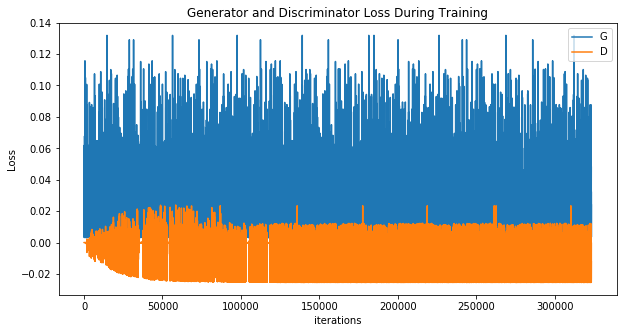

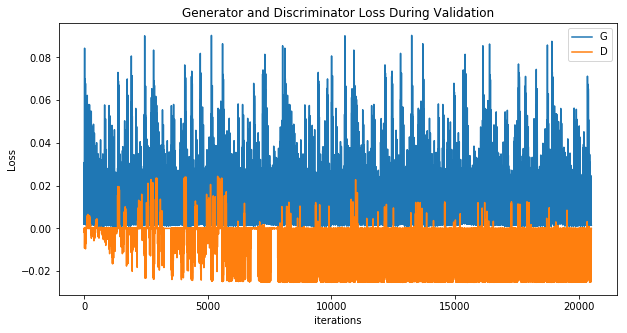

In [12]:
f=open('loss_history/train_loss_history.txt','rb')
train_loss = pickle.load(f)
f.close()
f=open('loss_history/train_loss_D_history.txt','rb')
train_D_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_history.txt','rb')
val_loss = pickle.load(f)
f.close()
f=open('loss_history/val_loss_D_history.txt','rb')
val_D_loss = pickle.load(f)
f.close()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(train_loss,label="G")
plt.plot(train_D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Validation")
plt.plot(val_loss,label="G")
plt.plot(val_D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
def check_result_images(step,slice=50):
    f=open('example_images/example_lr_step{}.txt'.format(step),'rb')
    lr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_sr_step{}.txt'.format(step),'rb')
    sr_patches = pickle.load(f)
    f.close()
    f=open('example_images/example_hr_step{}.txt'.format(step),'rb')
    hr_patches = pickle.load(f)
    f.close()
    f = plt.figure(figsize=(16,8))
    patch_size = lr_patches.shape[0]
    for patch in range(patch_size):
        sp = f.add_subplot(patch_size,3,patch*3+1)
        sp.axis('Off')
        sp.set_title('Low resolution image', fontsize=16)
        plt.imshow(lr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+2)
        sp.axis('Off')
        sp.set_title('Super resolution image', fontsize=16)
        plt.imshow(sr_patches[patch,0,slice,:,:],cmap='gray')
        
        sp = f.add_subplot(patch_size,3,patch*3+3)
        sp.axis('Off')
        sp.set_title('High resolution image', fontsize=16)
        plt.imshow(hr_patches[patch,0,slice,:,:],cmap='gray')


**Results of patches**

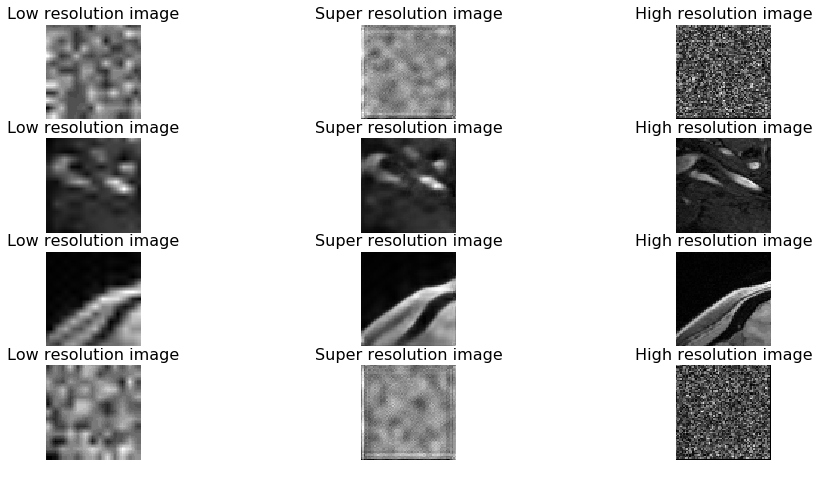

In [14]:
check_result_images(step=250000,slice=40)

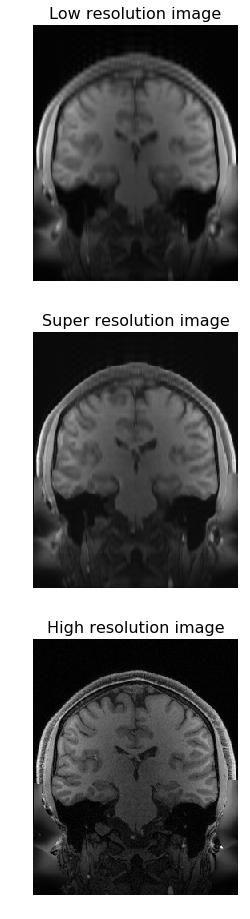

In [16]:
f=open('example_images/image_lr_step518200.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,:,140,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step518200.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,:,140,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step518200.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,:,140,:], 90)
plt.imshow(hr_show,cmap='gray')

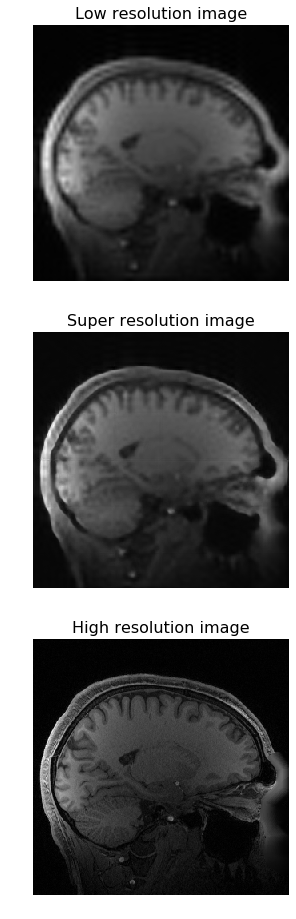

In [22]:
f=open('example_images/image_lr_step518200.txt','rb')
lr_image = pickle.load(f)
f.close()
fig = plt.figure(figsize=(16,16))
sp = fig.add_subplot(3,1,1)
sp.axis('Off')
sp.set_title('Low resolution image', fontsize=16)
lr_show=ndimage.rotate(lr_image[0,100,:,:], 90)
plt.imshow(lr_show,cmap='gray')
f=open('example_images/image_sr_step518200.txt','rb')
sr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,2)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
sr_show=ndimage.rotate(sr_image[0,100,:,:], 90)
plt.imshow(sr_show,cmap='gray')
f=open('example_images/image_hr_step518200.txt','rb')
hr_image = pickle.load(f)
f.close()
sp = fig.add_subplot(3,1,3)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
hr_show=ndimage.rotate(hr_image[0,100,:,:], 90)
plt.imshow(hr_show,cmap='gray')

## Test of depatching, and evaluation metrics ##

**Validation period patching and depatching**

In validation, evaluation, and test period, we need to input patches by order, and merge them to original image size. To reduce boundary effect, as is shown below, we cut each patches' margin by 3. After merging, we apply evaluation metrics on these images. Here is a demonstration that how this process works.

![Illustration of margin effect](./example_images/side_effect.png)

Here just for demonstration, we directly compare the evalutating measurements between a batch of low resolution images and their respective high resolution images. 

**Evaluation metrics**

To assess the quality of super-resolution, we used three image metrics: subject-wise average structural similarity index (SSIM), peak signal to noise ratio (PSNR), and normalized root mean squared error (NRMSE). They are all advanced and trusty metrics to assess the similarity between two images. The detailed calculations are:

$$
\operatorname{SSIM}(x, y)=\frac{\left(2 \mu_{x} \mu_{y}+c_{1}\right)\left(2 \sigma_{x y}+c_{2}\right)}{\left(\mu_{x}^{2}+\mu_{y}^{2}+c_{1}\right)\left(\sigma_{x}^{2}+\sigma_{y}^{2}+c_{2}\right)}
$$

$$
\begin{aligned} \mathrm{PSNR} &=10 \cdot \log _{10}\left(\frac{M A X_{I}^{2}}{M S E}\right) \\ &=20 \cdot \log _{10}\left(\frac{M A X_{I}}{\sqrt{M S E}}\right) \\ &=20 \cdot \log _{10}\left(M A X_{I}\right)-10 \cdot \log _{10}(M S E) \end{aligned}
$$

$$
\mathrm{NRMSE}=\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1}|y[m, n]-x[m, n]|^{2}}{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} x[m, n]^{2}}
$$

In [18]:
from ecbm6040.patching.patchloader import depatching
from ecbm6040.metric.eval_metrics import ssim, psnr, nrmse

Metrics: subject-wise mean SSIM = 0.8497, std = 0.0201; mean PSNR = 24.5129, std = 1.6780; mean NRMSE = 0.3677, std = 0.0300.


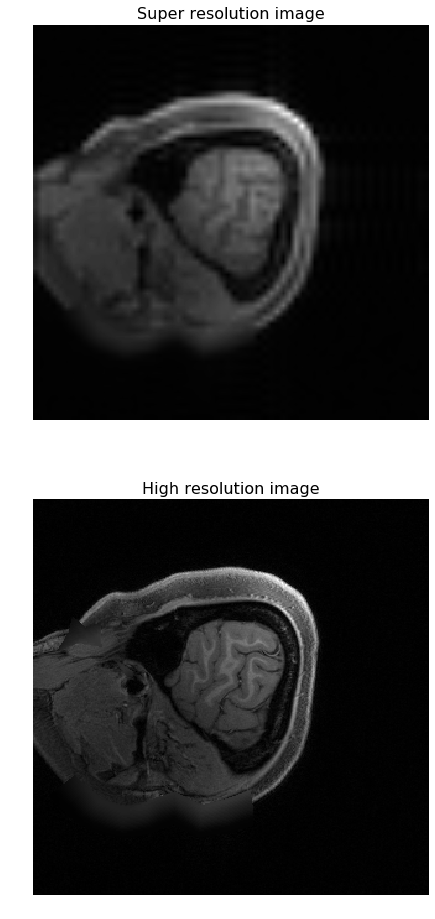

In [19]:
val_ssim = []
val_psnr = []
val_nrmse = []
for lr_data, hr_data in dataloaders['val']:
    patch_loader=patching(lr_data, hr_data, patch_size = patch_size, cube_size = cube_size, is_training=False)
    sr_data_cat = torch.Tensor([]) # for concatenation
    for lr_patches, hr_patches in patch_loader:
        lr_patches = lr_patches.cuda(device)        
        hr_patches = hr_patches.cuda(device)
        sr_patches = lr_patches
        # concatenate patches
        sr_data_cat = torch.cat([sr_data_cat, sr_patches.to("cpu")],0)
    sr_data = depatching(sr_data_cat, lr_data.size(0))
    batch_ssim = ssim(sr_data, hr_data)
    batch_psnr = psnr(sr_data, hr_data)
    batch_nrmse = nrmse(sr_data, hr_data)
    val_ssim = np.append(val_ssim, batch_ssim)
    val_psnr = np.append(val_psnr, batch_psnr)
    val_nrmse = np.append(val_nrmse, batch_nrmse)
    break
mean_ssim = np.mean(val_ssim)
std_ssim = np.std(val_ssim)
mean_psnr = np.mean(val_psnr)
std_psnr = np.std(val_psnr)
mean_nrmse = np.mean(val_nrmse)
std_nrmse = np.std(val_nrmse)
f = plt.figure(figsize=(8,16))
sp = f.add_subplot(2,1,1)
sp.axis('Off')
sp.set_title('Super resolution image', fontsize=16)
plt.imshow(sr_data[0,50,:,:],cmap='gray')
sp = f.add_subplot(2,1,2)
sp.axis('Off')
sp.set_title('High resolution image', fontsize=16)
plt.imshow(hr_data[0,50,:,:],cmap='gray')
print('Metrics: subject-wise mean SSIM = {:.4f}, std = {:.4f}; mean PSNR = {:.4f}, std = {:.4f}; mean NRMSE = {:.4f}, std = {:.4f}.'.format(mean_ssim, std_ssim, mean_psnr, std_psnr, mean_nrmse, std_nrmse))

## demo of test

We input 4 subjects from test set to see the results.

1) Test on pretrained Generator.

In [17]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, device)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/pretrained_G_step100000', pretrainedD=' ')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9225, std = 0.0174; mean PSNR = 30.1837, std = 1.8810; mean NRMSE = 0.2609, std = 0.0490.


In [23]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, device)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/pretrained_G_step250000', pretrainedD=' ')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9271, std = 0.0149; mean PSNR = 30.4294, std = 1.7253; mean NRMSE = 0.2530, std = 0.0439.


2) Test on mDCSRN+SRGAN.

In [31]:
wgan_gp = WGAN_GP(netG, netD, supervised_criterion, device)
wgan_gp.test(test_loader, patch_size=patch_size, pretrainedG='models/WGAN_G_step442000', pretrainedD='models/WGAN_D_step442000')

WGAN testing...
Metrics: subject-wise mean SSIM = 0.9331, std = 0.0081; mean PSNR = 30.5372, std = 1.3734; mean NRMSE = 0.2485, std = 0.0343.


## Discussion

1. Generator itself can conduct super-resolution. Inducing WGAN structure makes it better.
2. We start from extremely low resolution (256×64×64), which causes the task to be more difficult. The paper starts from not so "low" resolution (256×160×160).
3. Patching induces a problem: cubes that close to the edges of the image would be full of noise, which disturbs the training.